# (13) Fit -- cuda2

**Motivation**: Fitting notebook, cuda2 <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

## Trainer

In [2]:
vae = VAE(ConfigVAE(
    'fixate1', n_enc_cells=1, n_dec_cells=1, n_enc_nodes=3, n_dec_nodes=2,              
    n_latent_scales=3, n_groups_per_scale=8, n_latent_per_group=20,
))
tr = TrainerVAE(
    model=vae,
    cfg=ConfigTrainVAE(
        lr=0.004, batch_size=1000, epochs=400, grad_clip=1000,
        warm_restart=1, warmup_portion=0.025,
        lambda_anneal=True, lambda_init=1e-7, lambda_norm=1e-4, 
        kl_beta=0.20, kl_anneal_cycles=1, kl_anneal_portion=0.3, kl_const_portion=1e-4),
    device='cuda:2',
)
vae.cfg.total_latents()

280

In [3]:
vae.print()
vae.scales

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  16.1 Mil  |
|     ---      |    ---     |
|     stem     |    320     |
| pre_process  |  151.6 K   |
|  enc_tower   |  8.3 Mil   |
|     enc0     |   66.0 K   |
| enc_sampler  |  1.7 Mil   |
| dec_sampler  |  1.7 Mil   |
|    expand    |  234.2 K   |
|  dec_tower   |  3.8 Mil   |
| post_process |   67.9 K   |
|     out      |    578     |
+--------------+------------+

[8, 4, 2]

In [4]:
len(vae.all_conv_layers), len(vae.all_log_norm)

(151, 117)

## Review train options

In [5]:
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

fixate1_k-32_z-20x[2,4,8]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)
ep400-b1000-lr(0.004)_beta(0.2:1x0.3)_lamb(0.0001)_gr(1000)

In [6]:
print({
    k: v for k, v in vars(vae.cfg).items() if
    all(e not in k for e in ['useful', 'dir', 'path', 'file'])
})

{
    'sim': 'fixate1',
    'n_ch': 32,
    'ker_sz': 2,
    'input_sz': 17,
    'n_enc_cells': 1,
    'n_enc_nodes': 3,
    'n_dec_cells': 1,
    'n_dec_nodes': 2,
    'n_pre_cells': 3,
    'n_pre_blocks': 1,
    'n_post_cells': 3,
    'n_post_blocks': 1,
    'n_latent_scales': 3,
    'n_latent_per_group': 20,
    'n_groups_per_scale': 8,
    'spectral_norm': 0,
    'separable': False,
    'compress': True,
    'use_bn': False,
    'groups': [8, 4, 2],
    'seed': 0,
    'balanced_recon': True,
    'activation_fn': 'swish',
    'residual_kl': True,
    'scale_init': False,
    'ada_groups': True,
    'use_se': True
}

In [7]:
print(vars(tr.cfg))

{
    'lr': 0.004,
    'epochs': 400,
    'batch_size': 1000,
    'warm_restart': 1,
    'warmup_portion': 0.025,
    'optimizer': 'adamax_fast',
    'optimizer_kws': {'betas': (0.9, 0.999), 'weight_decay': 0.0003, 'eps': 1e-08},
    'scheduler_type': 'cosine',
    'scheduler_kws': {'T_max': 130.0, 'eta_min': 1e-05},
    'ema_rate': 0.999,
    'grad_clip': 1000,
    'chkpt_freq': 20,
    'eval_freq': 5,
    'log_freq': 10,
    'use_amp': False,
    'kl_beta': 0.2,
    'kl_beta_min': 0.0001,
    'kl_balancer': 'equal',
    'kl_anneal_cycles': 1,
    'kl_anneal_portion': 0.3,
    'kl_const_portion': 0.0001,
    'lambda_anneal': True,
    'lambda_init': 1e-07,
    'lambda_norm': 0.0001,
    'spectral_reg': False
}

## Train

In [11]:
comment = f"vlim:1_{tr.cfg.name()}"
tr.train(comment=comment)

epoch # 400, avg loss: 8.900648: 100%|██████████| 400/400 [40:32:51<00:00, 364.93s/it]                            


## Eval

In [17]:
%%time

val, loss = tr.validate(use_ema=False)
val_ema, loss_ema = tr.validate(use_ema=True)

CPU times: user 5min 47s, sys: 3min 17s, total: 9min 5s
Wall time: 14min 33s


In [18]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(f"{vae.cfg.name()}\n{tr.cfg.name()}\n\n{loss_summary}\n")

fixate1_k-32_z-20x[2,4,8]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)
ep400-b1000-lr(0.004)_beta(0.2:1x0.3)_lamb(0.0001)_gr(1000)

{'epe': {'vae': 2.31, 'ema': 2.3}, 'kl': {'vae': 33.2, 'ema': 33.22}}

In [19]:
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

fixate1_k-32_z-20x[2,4,8]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)
ep400-b1000-lr(0.004)_beta(0.2:1x0.3)_lamb(0.0001)_gr(1000)

fig/sample (VAE)

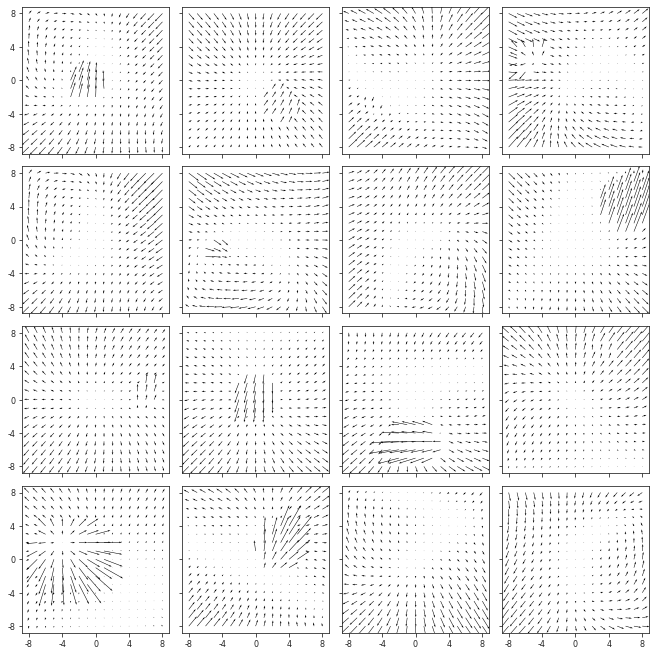

fig/sample (EMA)

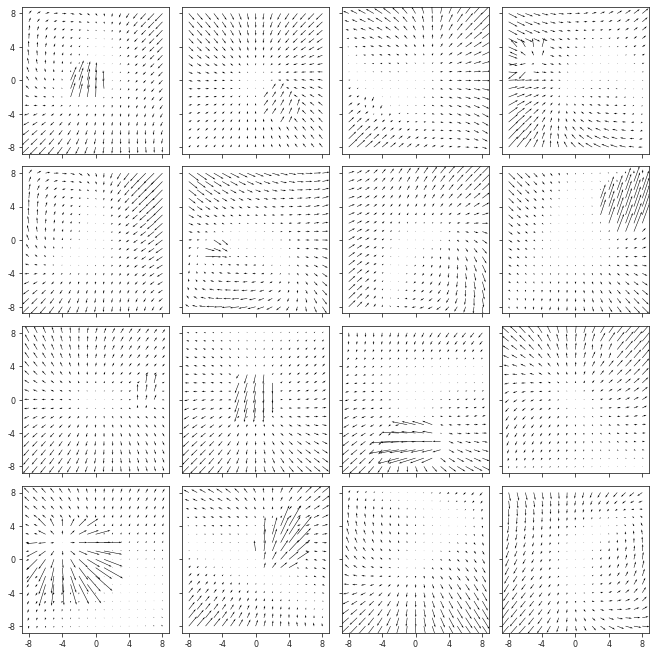

----------------------------------------------------------------------

fig/regression (VAE)

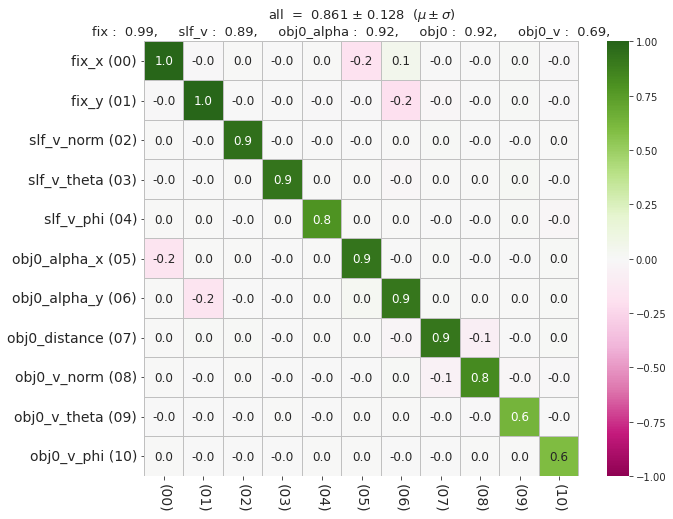

fig/regression (EMA)

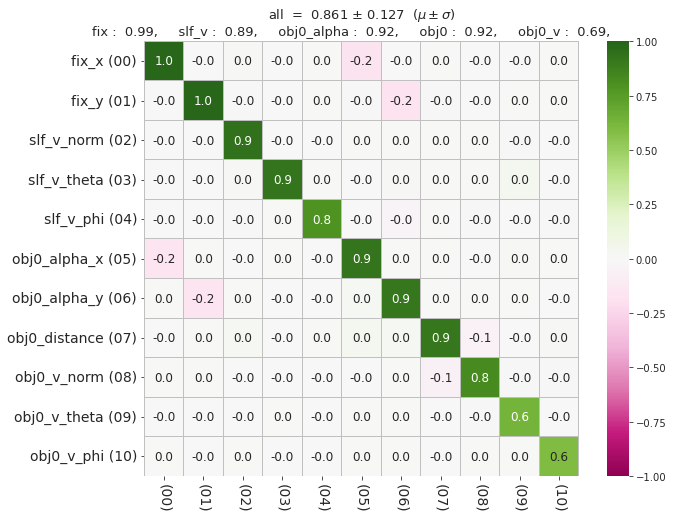

----------------------------------------------------------------------

fig/bar (VAE)

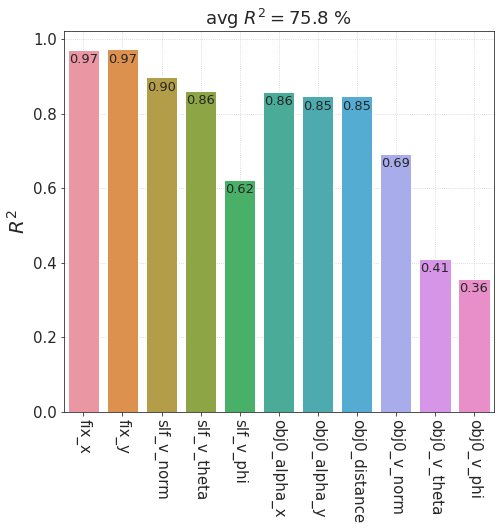

fig/bar (EMA)

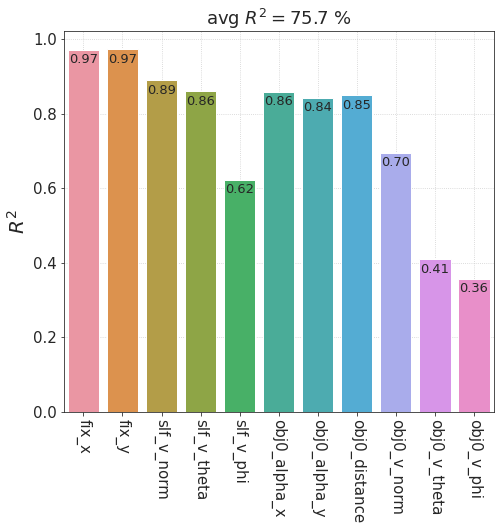

----------------------------------------------------------------------

fig/bar_aux (VAE)

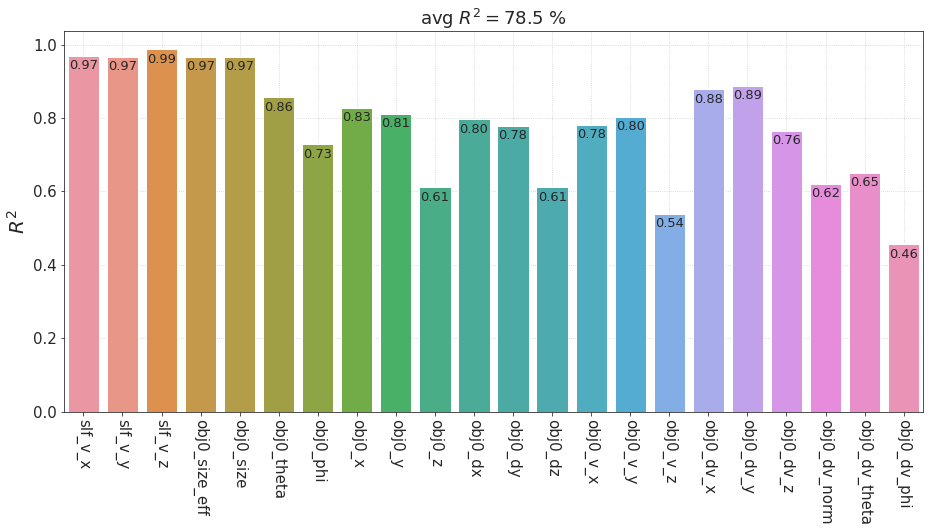

fig/bar_aux (EMA)

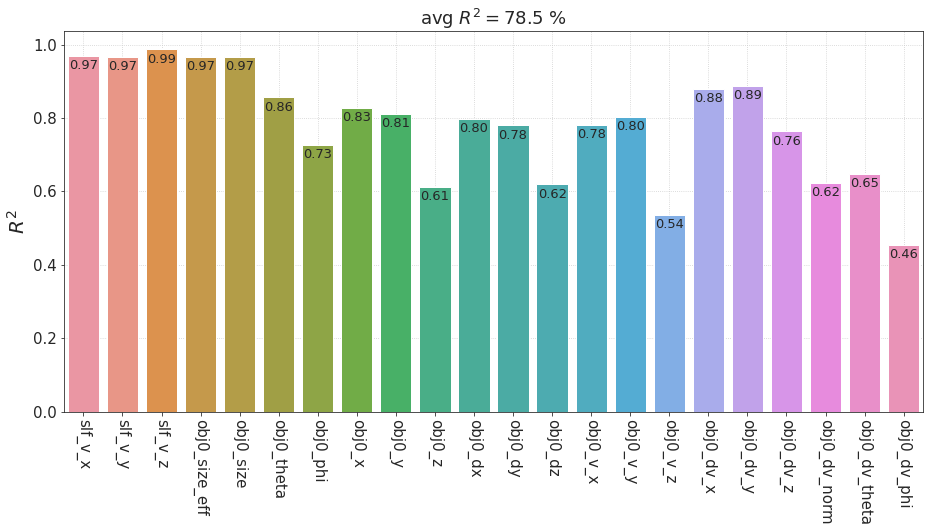

----------------------------------------------------------------------

fig/mutual_info (VAE)

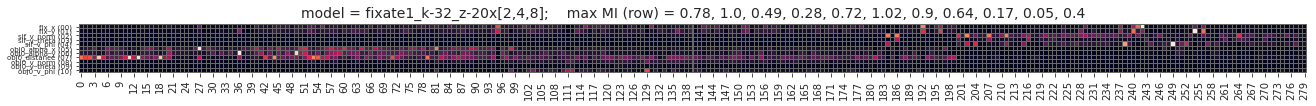

fig/mutual_info (EMA)

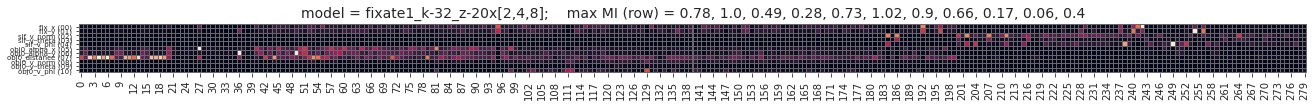

----------------------------------------------------------------------

In [20]:
for k, v in val.items():
    if 'fig' in k:
        print(f"{k} (VAE)")
        display(v)
        print(f"{k} (EMA)")
        display(val_ema[k])
        print('-' * 70)

In [23]:
df = pd.DataFrame({
    'x': tr.dl_vld.dataset.f_aux,
    'y': val_ema['regr/aux/r2'],
})

In [63]:
def plot_bar(df: pd.DataFrame, display: bool = True, **kwargs):
	defaults = dict(
		x='x',
		y='y',
		figsize_y=7,
		figsize_x=0.7,
		tick_labelsize_x=15,
		tick_labelsize_y=15,
		ylabel_fontsize=20,
		title_fontsize=18,
		vals_fontsize=13,
		title_y=1,
	)
	kwargs = setup_kwargs(defaults, kwargs)
	figsize = (
		kwargs['figsize_x'] * len(df),
		kwargs['figsize_y'],
	)
	fig, ax = create_figure(1, 1, figsize)
	bp = sns.barplot(data=df, x=kwargs['x'], y=kwargs['y'], ax=ax)
	barplot_add_vals(bp, fontsize=kwargs['vals_fontsize'])
	ax.tick_params(
		axis='x',
		rotation=-90,
		direction='out',
		labelsize=kwargs['tick_labelsize_x'],
	)
	ax.tick_params(axis='y', labelsize=kwargs['tick_labelsize_y'])
	title = r'avg $R^2 = $' + f"{np.nanmean(df[kwargs['y']]) * 100:0.1f} %"
	ax.set_title(title, fontsize=kwargs['title_fontsize'], y=kwargs['title_y'])
	ax.set_ylabel(r'$R^2$', fontsize=kwargs['ylabel_fontsize'])
	ax.set(xlabel='', ylim=(0, 1))
	ax.grid()
	if display:
		plt.show()
	else:
		plt.close()
	return fig, ax

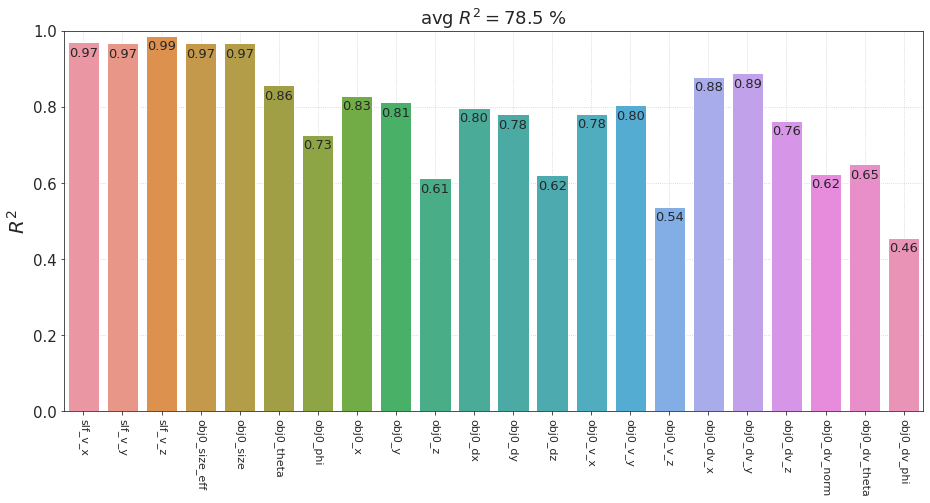

In [66]:
_ = plot_bar(df, tick_labelsize_x=11)

In [17]:
val_ema['z_vld'].shape

(75000, 280)

In [18]:
from analysis.linear import regress

In [20]:
reg_aux = regress(
    z=val_ema['z_vld'],
    z_tst=val_ema['z_tst'],
    g=tr.dl_vld.dataset.g_aux,
    g_tst=tr.dl_tst.dataset.g_aux,
)

array([0.80382406, 0.81422063, 0.78196368, 0.9829865 , 0.9829865 ,
       0.95870795, 0.78983396, 0.8458724 , 0.87414977, 0.65369568,
       0.93876955, 0.93888356, 0.65369945, 0.74629418, 0.74067537,
       0.55510709, 0.79845327, 0.79720424, 0.68254003, 0.62560167,
       0.5646017 , 0.39383906])

In [25]:
for _r2, _f in zip(reg_aux['r2'], tr.dl_vld.dataset.f_aux):
    print(_f, _r2 * 100)

slf_v_x 80.38240615591212

slf_v_y 81.42206290457983

slf_v_z 78.19636837273357

obj0_size_eff 98.29865013111548

obj0_size 98.29865013111548

obj0_theta 95.87079520455981

obj0_phi 78.98339612989813

obj0_x 84.58724005677209

obj0_y 87.41497736051423

obj0_z 65.3695683502914

obj0_dx 93.8769547490188

obj0_dy 93.88835632524726

obj0_dz 65.36994459173458

obj0_v_x 74.62941772973296

obj0_v_y 74.06753686234818

obj0_v_z 55.51070854879207

obj0_dv_x 79.84532679308725

obj0_dv_y 79.72042400623371

obj0_dv_z 68.25400279232343

obj0_dv_norm 62.56016673431544

obj0_dv_theta 56.46016956015634

obj0_dv_phi 39.38390610090286

In [69]:
list(tr.stats)

['eval/epe',
 'eval/kl',
 'eval/r2',
 'eval/r',
 'eval/r2_aux',
 'eval/r_aux',
 'eval/disentang',
 'eval/complete',
 'grad',
 'loss',
 'eval/mi',
 'eval/mi_norm',
 'eval/mig']

In [76]:
len(tr.stats['grad'])

234

In [15]:
np.quantile(tr.stats['loss'], [0.5, 0.7, 0.9, 1])

array([1.83597097e+01, 3.33677979e+01, 1.99485512e+02, 5.41584938e+05])

In [16]:
gamma = np.stack(tr.stats['gamma'])
gamma.shape

(160000, 30)

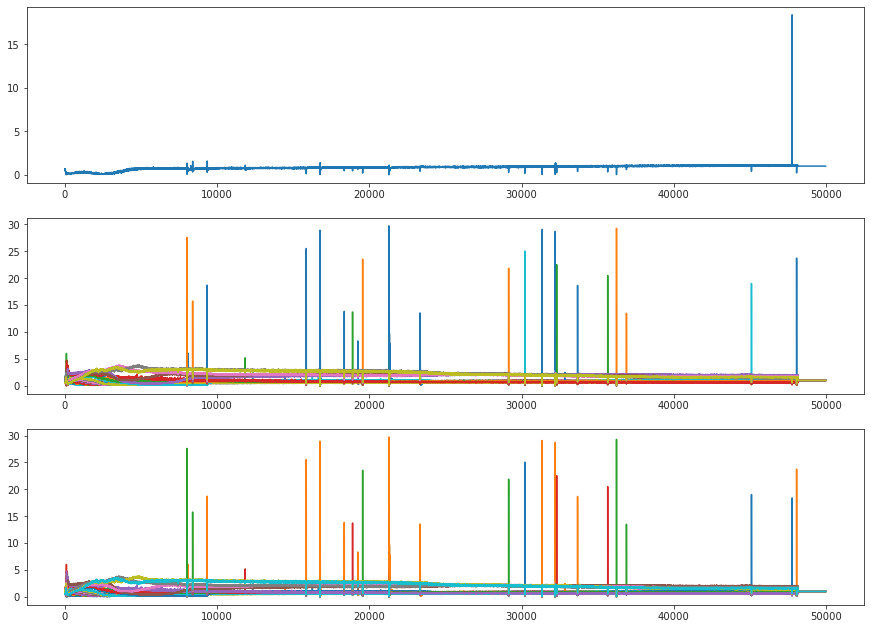

In [17]:
fig, axes = create_figure(3, 1, (15, 11))
axes[0].plot(gamma[:50000, 0])
axes[1].plot(gamma[:50000, 1:])
axes[2].plot(gamma[:50000]);